## Health impact forecasting

Main goal of this m=notebook is to build a time series model to forecast the future impact of smoke on health, particular asthma and copd hospitalization and mortality

### License:
All code is under MIT license.

Note: Some snippets from this code are taken from ChatGPT to imporve code efficiency.

The below libraries are a pre-requisite to be installed to run the notebook. Uncomment the below cell to install the libraries.

In [2]:
# %pip install statsmodels

In [3]:
# IMPORTS
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [4]:
# read the smoke and health data we analysed
mortality_asthma_copd_df = pd.read_csv('../intermediary_files/mortality_asthma_copd.csv')

hospitalization_asthma_copd_df =  pd.read_csv('../intermediary_files/hospitalization_asthma_copd.csv')

forcasted_smoke_estimates = pd.read_csv('../intermediary_files/smoke_estimates_with_forecast.csv')
forcasted_smoke_estimates = forcasted_smoke_estimates[forcasted_smoke_estimates['year'] > 2020]

In [5]:
mortality_asthma_copd_df

,Unnamed: 0,year,sex,Value,condition,smoke_estimate
0,0,2010,Male,9.9,COPD,30.668830
1,1,2010,Male,9.9,COPD,8.707322
2,2,2010,Male,9.9,COPD,2.119830
3,3,2010,Male,9.9,COPD,22.389660
4,4,2010,Male,9.9,COPD,16.201209
...,...,...,...,...,...,...
23219,23219,2020,Female,1.9,Asthma,0.003658
23220,23220,2020,Female,1.9,Asthma,0.010507
23221,23221,2020,Female,1.9,Asthma,0.008430
23222,23222,2020,Female,1.9,Asthma,0.001402


Following code prepares data to analyze the relationship between smoke exposure and health outcomes (mortality and hospitalizations for asthma and COPD) over time. 

In [6]:
# prepare mortality data
mortality_asthma_copd_df['sex'] = mortality_asthma_copd_df['sex'].replace({'Male': 1, 'Female': 2, 'Both': 3})
# mortality_asthma_copd_df.set_index('year', inplace=True)  # Set year as index
y = mortality_asthma_copd_df.groupby('year')['Value'].mean()  # Target variable - when cause is not considered
X = mortality_asthma_copd_df.groupby('year')['smoke_estimate'].mean()  # Predictor

/var/folders/ld/y0zsw11s34q_fr6m889pmps40000gp/T/ipykernel_92838/2421296935.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mortality_asthma_copd_df['sex'] = mortality_asthma_copd_df['sex'].replace({'Male': 1, 'Female': 2, 'Both': 3})


In [7]:
hospitalization_asthma_copd_df.head()

,Unnamed: 0,year,sex,Value,condition,smoke_estimate
0,0,2010,Male,9.9,COPD,30.668830
1,1,2010,Male,9.9,COPD,8.707322
2,2,2010,Male,9.9,COPD,2.119830
3,3,2010,Male,9.9,COPD,22.389660
4,4,2010,Male,9.9,COPD,16.201209


In [8]:
# Step 1: Prepare hosp Data
hospitalization_asthma_copd_df['sex'] = hospitalization_asthma_copd_df['sex'].replace({'Male': 1, 'Female': 2, 'Both': 3})

Asthma_hosp_df = hospitalization_asthma_copd_df[hospitalization_asthma_copd_df['condition'] == 'Asthma']
copd_hosp_df = hospitalization_asthma_copd_df[hospitalization_asthma_copd_df['condition'] == 'COPD']

male_asthma_hosp_df = Asthma_hosp_df[Asthma_hosp_df["sex"]==1]
male_copd_hosp_df = copd_hosp_df[copd_hosp_df["sex"]==1]

female_asthma_hosp_df = Asthma_hosp_df[Asthma_hosp_df["sex"]==2]
female_copd_hosp_df = copd_hosp_df[copd_hosp_df["sex"]==2]


y_asthma_hosp = Asthma_hosp_df.groupby('year')['Value'].sum()  # Target variable
X_asthma_hosp = Asthma_hosp_df.groupby('year')['smoke_estimate'].mean()  # Predictor

y_copd_hosp = copd_hosp_df.groupby('year')['Value'].sum()  # Target variable
X_copd_hosp = copd_hosp_df.groupby('year')['smoke_estimate'].mean()  # Predictor

# male
y_male_asthma_hosp = male_asthma_hosp_df.groupby('year')['Value'].sum()  # Target variable
X_male_asthma_hosp = male_asthma_hosp_df.groupby('year')['smoke_estimate'].mean()  # Predictor

y_male_copd_hosp = male_copd_hosp_df.groupby('year')['Value'].sum()  # Target variable
X_male_copd_hosp = male_copd_hosp_df.groupby('year')['smoke_estimate'].mean()  # Predictor

# female
y_female_asthma_hosp = female_asthma_hosp_df.groupby('year')['Value'].sum()  # Target variable
X_female_asthma_hosp = female_asthma_hosp_df.groupby('year')['smoke_estimate'].mean()  # Predictor

y_female_copd_hosp = female_copd_hosp_df.groupby('year')['Value'].sum()  # Target variable
X_female_copd_hosp = female_copd_hosp_df.groupby('year')['smoke_estimate'].mean()  # Predictor


/var/folders/ld/y0zsw11s34q_fr6m889pmps40000gp/T/ipykernel_92838/959273823.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hospitalization_asthma_copd_df['sex'] = hospitalization_asthma_copd_df['sex'].replace({'Male': 1, 'Female': 2, 'Both': 3})


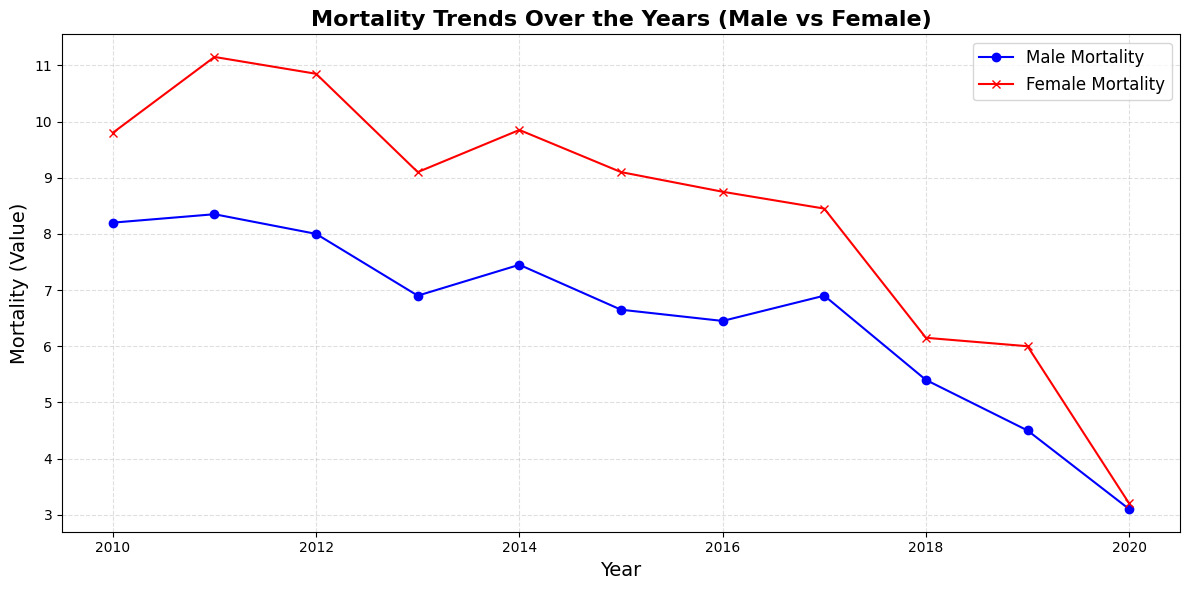

In [9]:

# Filter the data for male and female
male_data = mortality_asthma_copd_df[mortality_asthma_copd_df['sex'] == 1]
female_data = mortality_asthma_copd_df[mortality_asthma_copd_df['sex'] == 2]

# Group data by year and calculate the sum of mortality ('mx') for each gender
male_mortality = male_data.groupby('year')['Value'].mean()
female_mortality = female_data.groupby('year')['Value'].mean()

# Plot the data
plt.figure(figsize=(12, 6))

plt.plot(male_mortality.index, male_mortality.values, label='Male Mortality', color='blue', marker='o')
plt.plot(female_mortality.index, female_mortality.values, label='Female Mortality', color='red', marker='x')

# Add labels, title, and legend
plt.title('Mortality Trends Over the Years (Male vs Female)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mortality (Value)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4, linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()


This chart highlights the gender disparity in mortality rates, with males consistently experiencing higher rates but both male and female mortality seem to be reducing over time.

In [10]:
# create dataframe for modelling
df_combined = pd.DataFrame({'smoke_estimates': X, 'mortality': y})

### Forcast for mortality with smoke estimates when cause of death is not considered

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmo

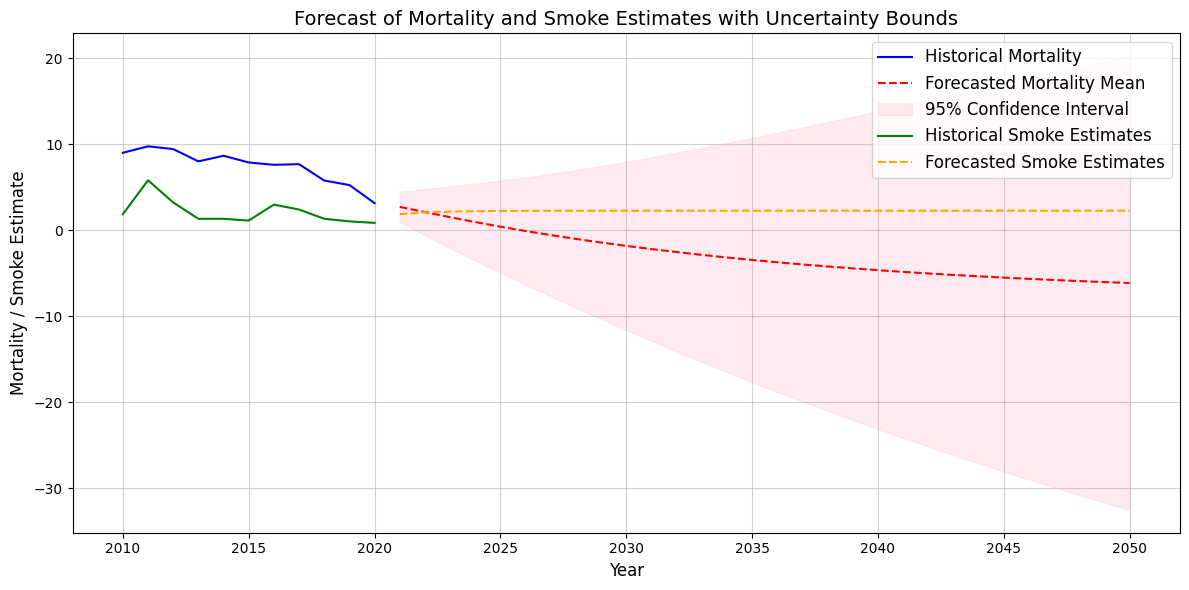

In [11]:
# Step 3: Build SARIMAX Model
model = SARIMAX(df_combined['mortality'], exog=df_combined['smoke_estimates'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Step 2: Forecast with Confidence Intervals
forecast = model_fit.get_forecast(steps=30, exog=forcasted_smoke_estimates['annual_smoke_estimate'])  # Forecast 30 years into the future
forecast_index = pd.RangeIndex(start=df_combined.index[-1] + 1, stop=df_combined.index[-1] + 31)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))

# Plot historical mortality data
plt.plot(
    df_combined.index,
    df_combined['mortality'],
    label='Historical Mortality',
    color='blue',
    linestyle='-'
)

# Plot forecast mean
plt.plot(
    forecast_index,
    forecast_mean,
    label='Forecasted Mortality Mean',
    color='red',
    linestyle='--'
)

# Plot confidence intervals
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)

# Plot smoke estimates (historical and forecasted)
plt.plot(
    df_combined.index,
    df_combined['smoke_estimates'],
    label='Historical Smoke Estimates',
    color='green',
    linestyle='-'
)
plt.plot(
    forecast_index,
    forcasted_smoke_estimates['annual_smoke_estimate'],
    label='Forecasted Smoke Estimates',
    color='orange',
    linestyle='--'
)

# Add labels, title, and legend
plt.title('Forecast of Mortality and Smoke Estimates with Uncertainty Bounds', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mortality / Smoke Estimate', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()



Mortality seems to decreases with constant smoke estimates over the next 30 years without the cause of death considered. AS the correlation for mortality with smoke estimates was weak I have decided to build a model for hospitalisation and also study the impact on gender and difference cause.

### Forcast for Asthma hospitalization

In [12]:
df_combined_asthma = pd.DataFrame({'smoke_estimates': X_asthma_hosp, 'hospitalization': y_asthma_hosp})
df_combined_asthma_male = pd.DataFrame({'smoke_estimates': X_male_asthma_hosp, 'hospitalization': y_male_asthma_hosp})
df_combined_asthma_female = pd.DataFrame({'smoke_estimates': X_female_asthma_hosp, 'hospitalization': y_female_asthma_hosp})

Overal hospitalization for asthma irrespective of gender

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmo

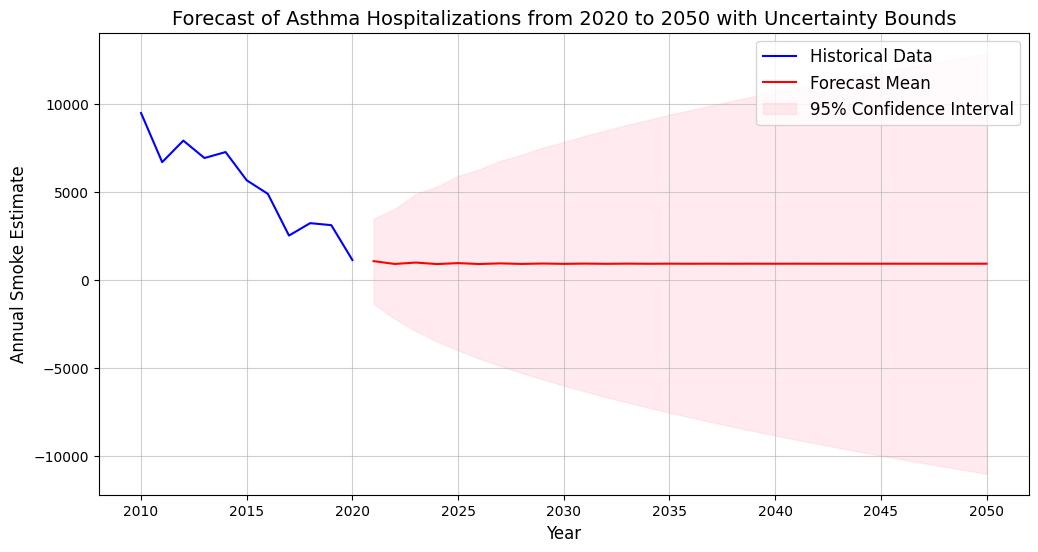

In [13]:
# Step 3: Build SARIMAX Model
model = SARIMAX(df_combined_asthma['hospitalization'], exog=df_combined_asthma['smoke_estimates'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Step 2: Forecast with Confidence Intervals
forecast = model_fit.get_forecast(steps=30, exog=forcasted_smoke_estimates['annual_smoke_estimate'])  # Forecast 30 years into the future
forecast_index = pd.RangeIndex(start=df_combined_asthma.index[-1] + 1, stop=df_combined_asthma.index[-1] + 31)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Step 3: Plot Historical Data and Forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(df_combined_asthma.index, df_combined_asthma['hospitalization'], label='Historical Data', color='blue')

# Plot forecast mean
plt.plot(forecast_index, forecast_mean, label='Forecast Mean', color='red')

# Plot confidence intervals
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title('Forecast of Asthma Hospitalizations from 2020 to 2050 with Uncertainty Bounds', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Annual Smoke Estimate', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.6)
plt.show()


Overall hospitalization due to Asthma seem to stay constant

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stat

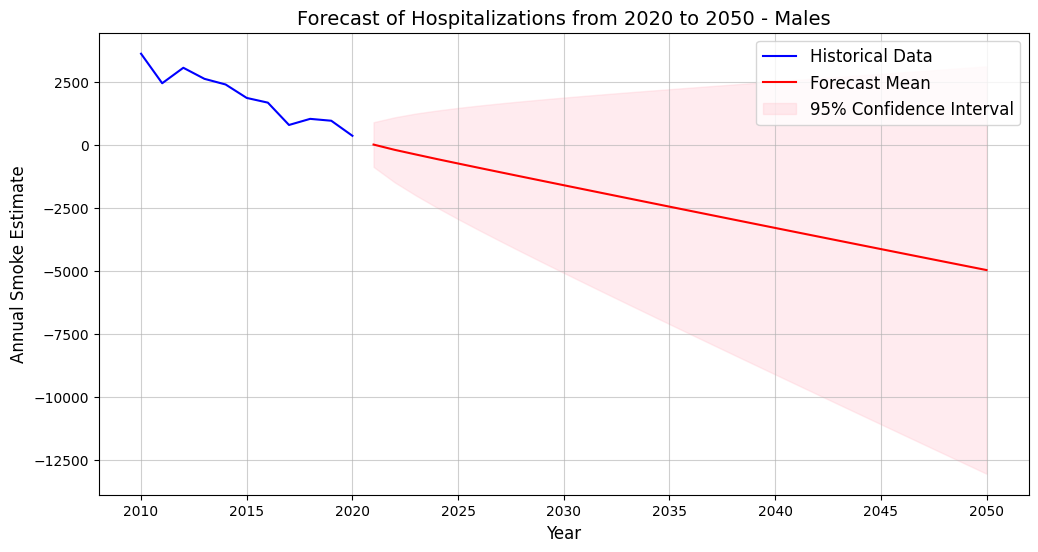

In [14]:
# Step 1: Build SARIMAX Model
model = SARIMAX(df_combined_asthma_male['hospitalization'], exog=df_combined_asthma_male['smoke_estimates'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Step 2: Forecast with Confidence Intervals
forecast = model_fit.get_forecast(steps=30, exog=forcasted_smoke_estimates['annual_smoke_estimate'])  # Forecast 30 years into the future
forecast_index = pd.RangeIndex(start=df_combined_asthma_male.index[-1] + 1, stop=df_combined_asthma_male.index[-1] + 31)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Step 3: Plot Historical Data and Forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(df_combined_asthma_male.index, df_combined_asthma_male['hospitalization'], label='Historical Data', color='blue')

# Plot forecast mean
plt.plot(forecast_index, forecast_mean, label='Forecast Mean', color='red')

# Plot confidence intervals
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title('Forecast of Hospitalizations from 2020 to 2050 - Males', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Annual Smoke Estimate', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.6)
plt.show()

Due to lack of proper data here we see the forecast for males is going below zero but overall have a downward trend

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stat

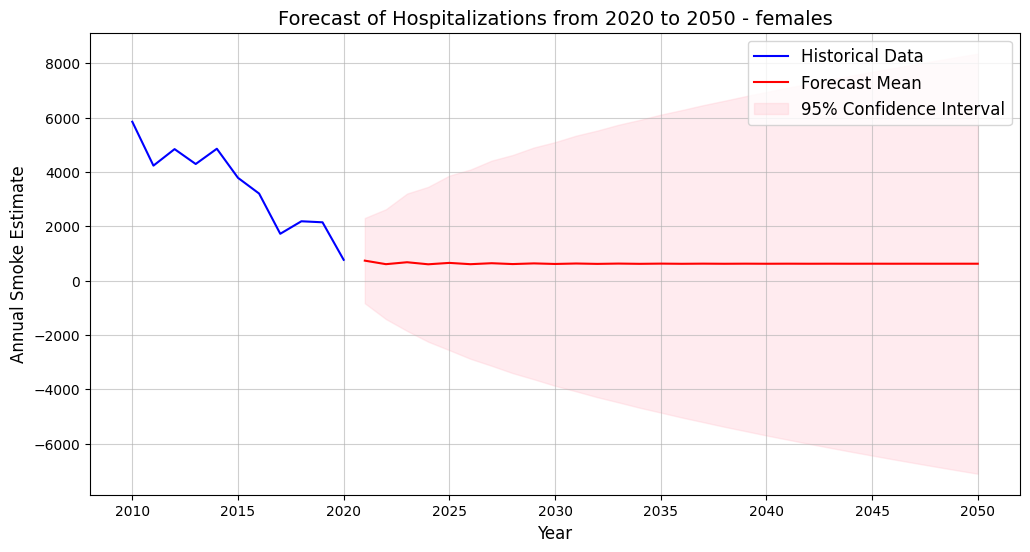

In [15]:
# Step 1: Build SARIMAX Model
model = SARIMAX(df_combined_asthma_female['hospitalization'], exog=df_combined_asthma_female['smoke_estimates'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Step 2: Forecast with Confidence Intervals
forecast = model_fit.get_forecast(steps=30, exog=forcasted_smoke_estimates['annual_smoke_estimate'])  # Forecast 30 years into the future
forecast_index = pd.RangeIndex(start=df_combined_asthma_female.index[-1] + 1, stop=df_combined_asthma_female.index[-1] + 31)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Step 3: Plot Historical Data and Forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(df_combined_asthma_female.index, df_combined_asthma_female['hospitalization'], label='Historical Data', color='blue')

# Plot forecast mean
plt.plot(forecast_index, forecast_mean, label='Forecast Mean', color='red')

# Plot confidence intervals
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title('Forecast of Hospitalizations from 2020 to 2050 - females', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Annual Smoke Estimate', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.6)
plt.show()

### Forecast for COPD hospitalization

Overall trend for COPD without gender

In [16]:
df_combined_copd = pd.DataFrame({'smoke_estimates': X_copd_hosp, 'hospitalization': y_copd_hosp})
df_combined_copd_male = pd.DataFrame({'smoke_estimates': X_male_copd_hosp, 'hospitalization': y_male_copd_hosp})
df_combined_copd_female = pd.DataFrame({'smoke_estimates': X_female_copd_hosp, 'hospitalization': y_female_copd_hosp})

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/

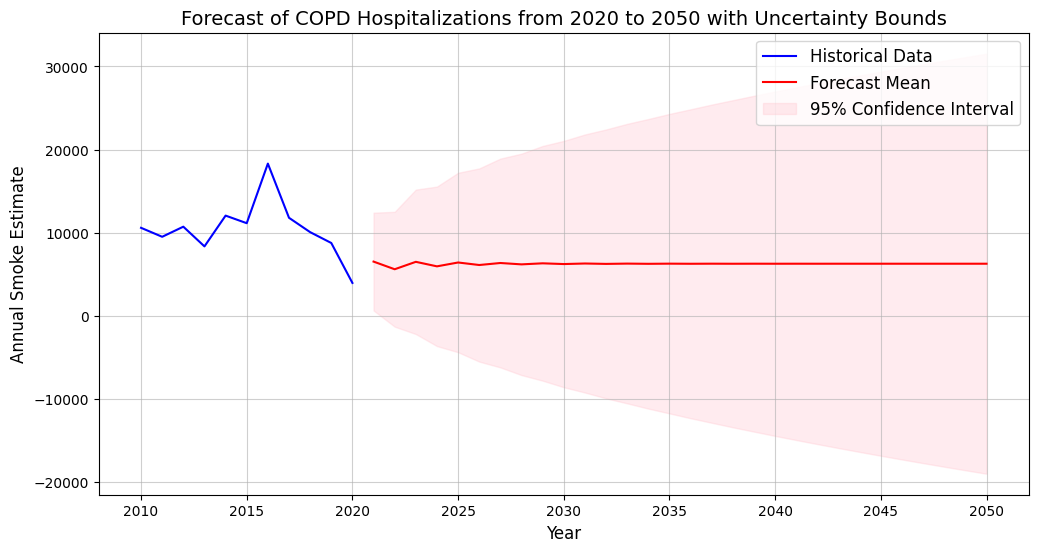

In [17]:
# Step 3: Build SARIMAX Model
model = SARIMAX(df_combined_copd['hospitalization'], exog=df_combined_copd['smoke_estimates'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Step 2: Forecast with Confidence Intervals
forecast = model_fit.get_forecast(steps=30, exog=forcasted_smoke_estimates['annual_smoke_estimate'])  # Forecast 30 years into the future
forecast_index = pd.RangeIndex(start=df_combined_copd.index[-1] + 1, stop=df_combined_copd.index[-1] + 31)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Step 3: Plot Historical Data and Forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(df_combined_copd.index, df_combined_copd['hospitalization'], label='Historical Data', color='blue')

# Plot forecast mean
plt.plot(forecast_index, forecast_mean, label='Forecast Mean', color='red')

# Plot confidence intervals
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title('Forecast of COPD Hospitalizations from 2020 to 2050 with Uncertainty Bounds', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Annual Smoke Estimate', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.6)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stat

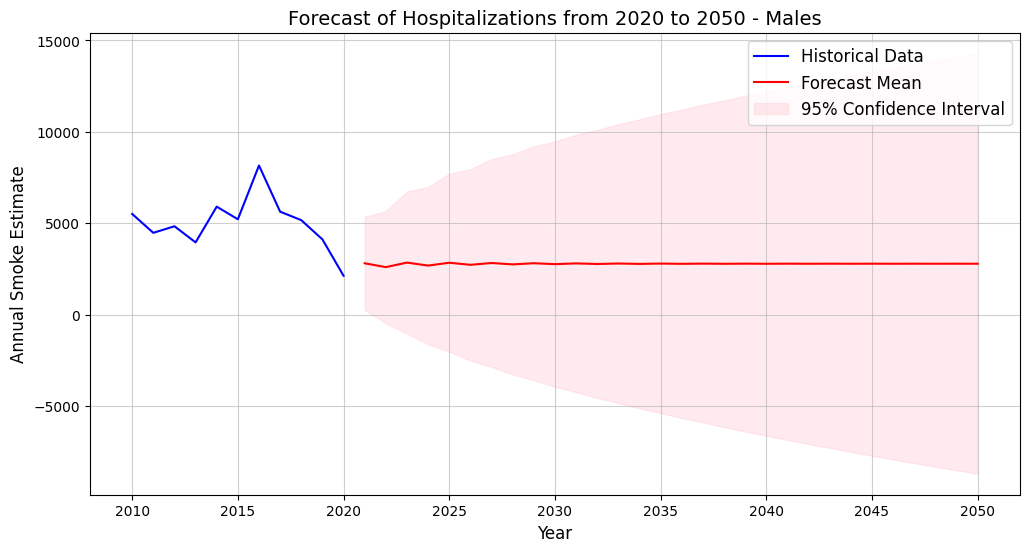

In [ ]:
# Step 1: Build SARIMAX Model
model = SARIMAX(df_combined_copd_male['hospitalization'], exog=df_combined_copd_male['smoke_estimates'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Step 2: Forecast with Confidence Intervals
forecast = model_fit.get_forecast(steps=30, exog=forcasted_smoke_estimates['annual_smoke_estimate'])  # Forecast 30 years into the future
forecast_index = pd.RangeIndex(start=df_combined_copd_male.index[-1] + 1, stop=df_combined_copd_male.index[-1] + 31)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Step 3: Plot Historical Data and Forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(df_combined_copd_male.index, df_combined_copd_male['hospitalization'], label='Historical Data', color='blue')

# Plot forecast mean
plt.plot(forecast_index, forecast_mean, label='Forecast Mean', color='red')

# Plot confidence intervals
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title('Forecast of COPD Hospitalizations from 2020 to 2050 - Males', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Annual Smoke Estimate', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.6)
plt.show()

In [19]:
forcast_df = pd.DataFrame({'years': forecast_index, 'hosp': forecast_mean}).set_index('years')

forcast_df.min()

hosp    2606.34255
dtype: float64

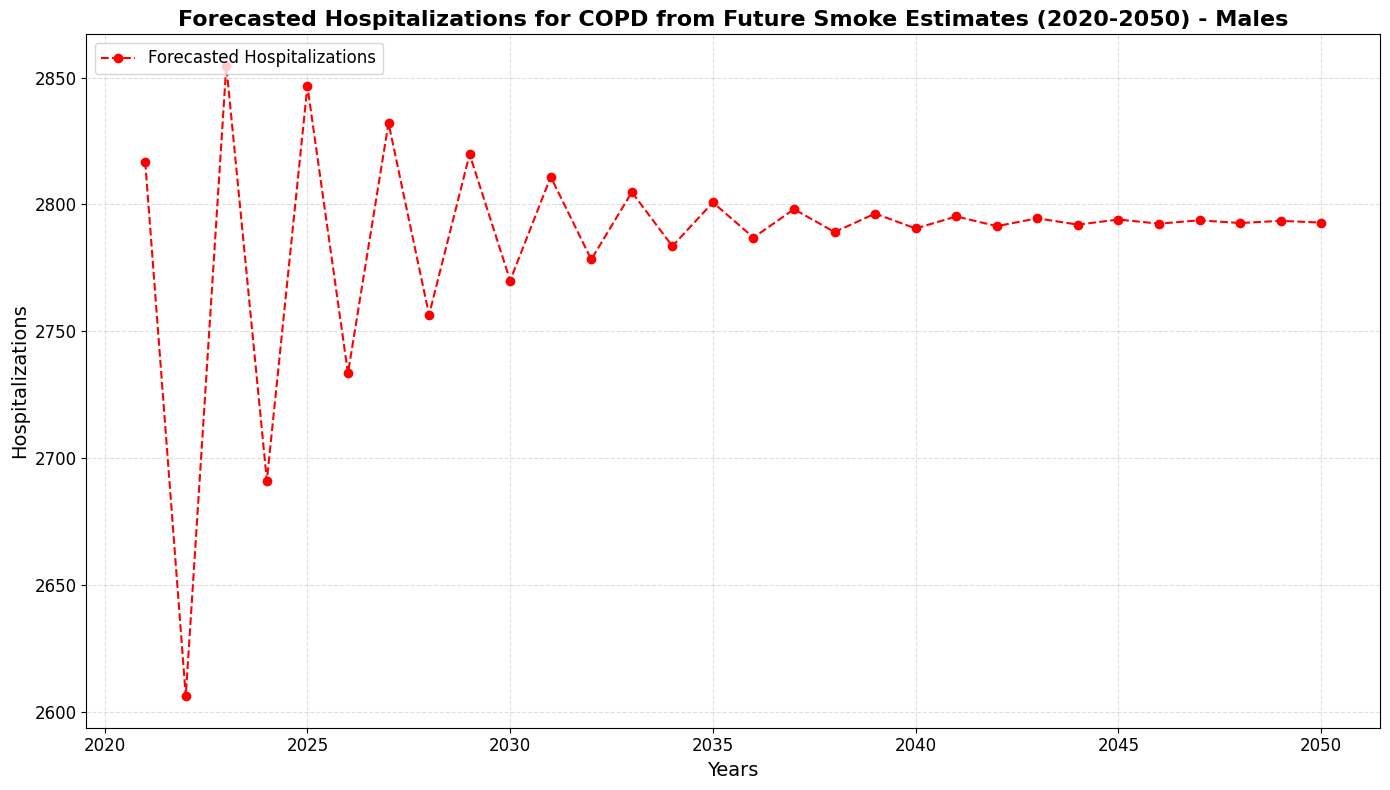

In [20]:
# Create a clean plot for future hospitalization forecast
plt.figure(figsize=(14, 8))

# Plot forecast mean
plt.plot(
    forcast_df.index,
    forcast_df['hosp'],
    label='Forecasted Hospitalizations',
    color='red',
    linestyle='--',
    marker='o',
    # linewidth=2
)

# Add labels, title, and legend
plt.title('Forecasted Hospitalizations for COPD from Future Smoke Estimates (2020-2050) - Males', fontsize=16, fontweight='bold')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Hospitalizations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(alpha=0.4, linestyle='--')

# Adjust layout for a cleaner look
plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stat

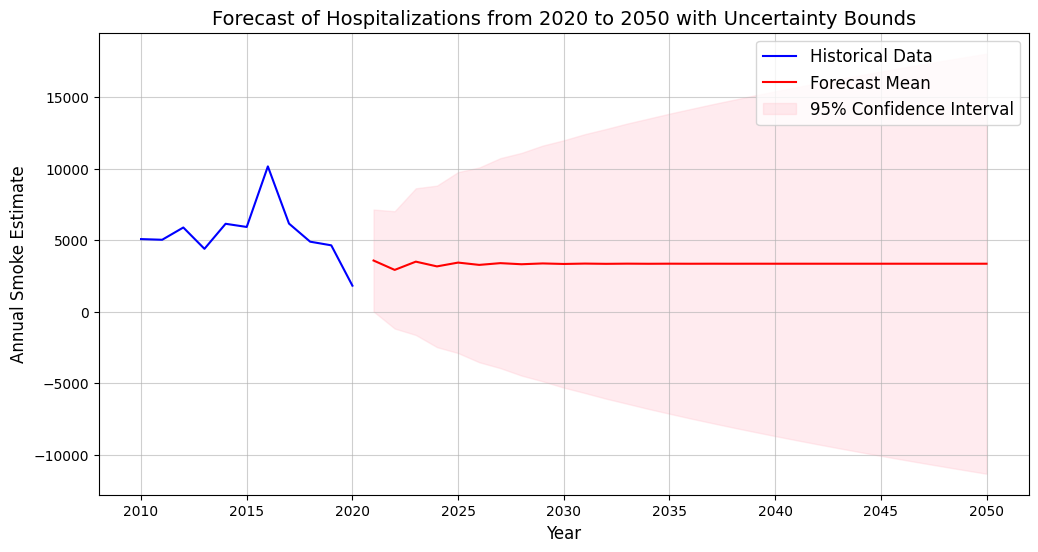

In [21]:
# Step 1: Build SARIMAX Model
model = SARIMAX(df_combined_copd_female['hospitalization'], exog=df_combined_copd_female['smoke_estimates'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Step 2: Forecast with Confidence Intervals
forecast = model_fit.get_forecast(steps=30, exog=forcasted_smoke_estimates['annual_smoke_estimate'])  # Forecast 30 years into the future
forecast_index = pd.RangeIndex(start=df_combined_copd_female.index[-1] + 1, stop=df_combined_copd_female.index[-1] + 31)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Step 3: Plot Historical Data and Forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(df_combined_copd_female.index, df_combined_copd_female['hospitalization'], label='Historical Data', color='blue')

# Plot forecast mean
plt.plot(forecast_index, forecast_mean, label='Forecast Mean', color='red')

# Plot confidence intervals
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title('Forecast of Hospitalizations from 2020 to 2050 with Uncertainty Bounds', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Annual Smoke Estimate', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.6)
plt.show()

In [22]:
forcast_df = pd.DataFrame({'years': forecast_index, 'hosp': forecast_mean}).set_index('years')

forcast_df.min()

hosp    2916.064456
dtype: float64

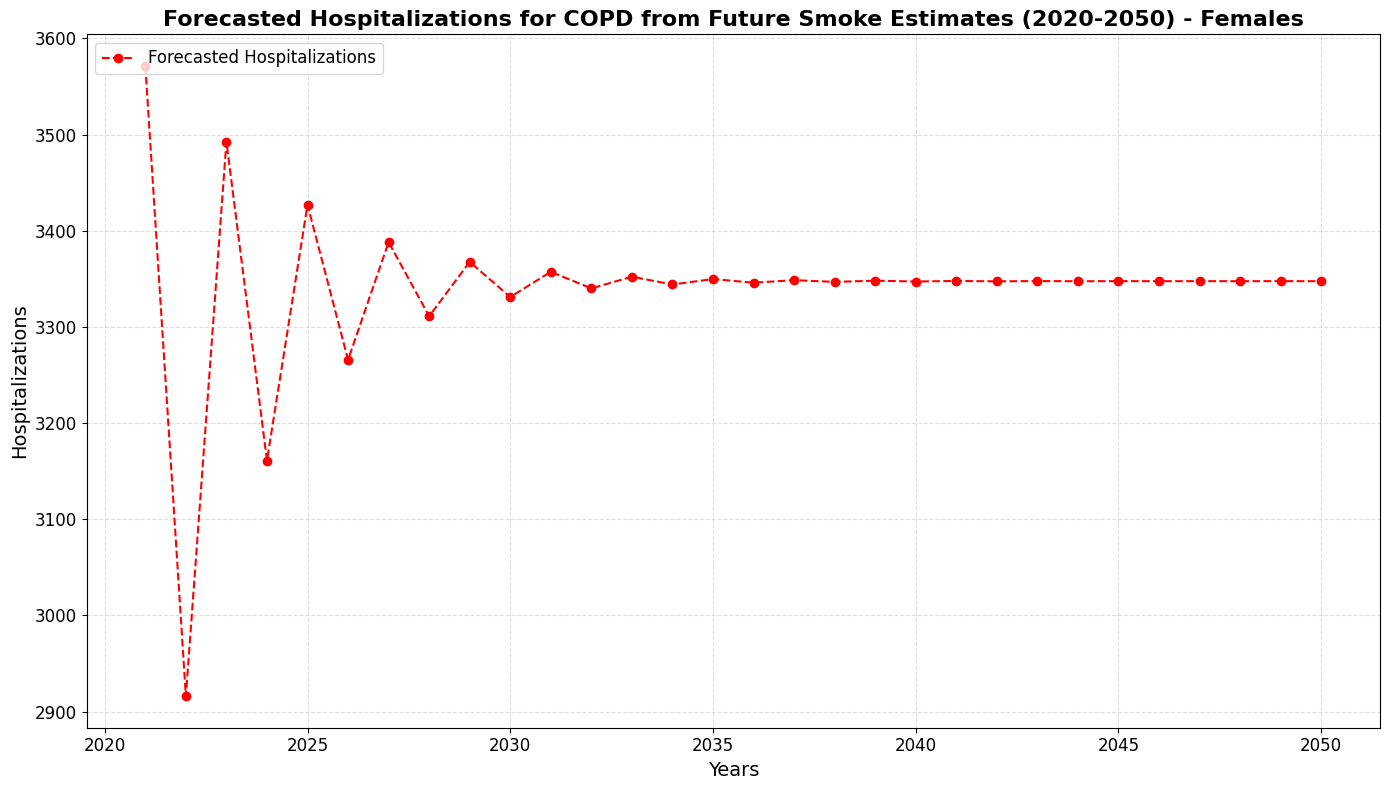

In [23]:
# Create a clean plot for future hospitalization forecast
plt.figure(figsize=(14, 8))

# Plot forecast mean
plt.plot(
    forcast_df.index,
    forcast_df['hosp'],
    label='Forecasted Hospitalizations',
    color='red',
    linestyle='--',
    marker='o',
    # linewidth=2
)

# Add labels, title, and legend
plt.title('Forecasted Hospitalizations for COPD from Future Smoke Estimates (2020-2050) - Females', fontsize=16, fontweight='bold')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Hospitalizations', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(alpha=0.4, linestyle='--')

# Adjust layout for a cleaner look
plt.tight_layout()
plt.show()


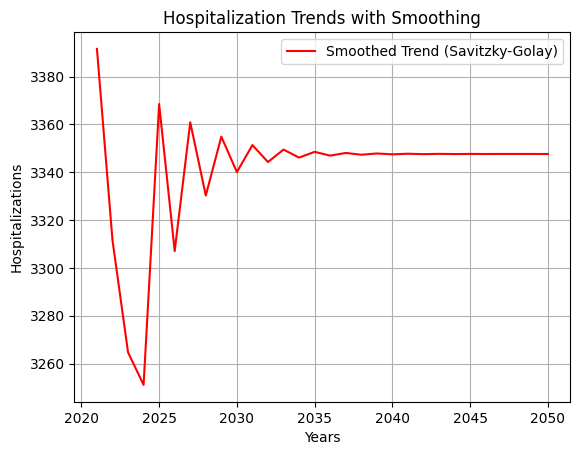

In [24]:

from scipy.signal import savgol_filter

# Calculate rolling mean for smoothing
forcast_df['hosp_smoothed'] = forcast_df['hosp'].rolling(window=5, center=True).mean()

# Apply Savitzky-Golay filter for further smoothing
forcast_df['hosp_trend'] = savgol_filter(forcast_df['hosp'], window_length=7, polyorder=2)

# Plot the Savitzky-Golay trend
plt.plot(forcast_df.index, forcast_df['hosp_trend'], label='Smoothed Trend (Savitzky-Golay)', color='red')

# Add labels, legend, and title
plt.title('Hospitalization Trends with Smoothing')
plt.xlabel('Years')
plt.ylabel('Hospitalizations')
plt.legend()
plt.grid()
plt.show()
